# Assignment 1A - Question 2

## Classification

In [2]:
import pandas
import numpy
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC, NuSVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from scipy.stats import norm
from sklearn import tree

### Import files
Files imported using pandas.read_csv

Check values using .head()

In [3]:
train = pandas.read_csv('CAB420_Assessment_1A_Data/Data/Q2/training.csv')
test = pandas.read_csv('CAB420_Assessment_1A_Data/Data/Q2/testing.csv')
train.head()

,class,b1,b2,b3,b4,b5,b6,b7,b8,b9,...,pred_minus_obs_H_b9,pred_minus_obs_S_b1,pred_minus_obs_S_b2,pred_minus_obs_S_b3,pred_minus_obs_S_b4,pred_minus_obs_S_b5,pred_minus_obs_S_b6,pred_minus_obs_S_b7,pred_minus_obs_S_b8,pred_minus_obs_S_b9
0,d,39,36,57,91,59,101,93,27,60,...,-2.36,-18.41,-1.88,-6.43,-21.03,-1.60,-6.18,-22.50,-5.20,-7.86
1,h,84,30,57,112,51,98,92,26,62,...,-2.26,-16.27,-1.95,-6.25,-18.79,-1.99,-6.18,-23.41,-8.87,-10.83
2,s,53,25,49,99,51,93,84,26,58,...,-1.46,-15.92,-1.79,-4.64,-17.73,-0.48,-4.69,-19.97,-4.10,-7.07
3,s,59,26,49,103,47,92,82,25,56,...,2.68,-13.77,-2.53,-6.34,-22.03,-2.34,-6.60,-27.10,-7.99,-10.81
4,d,57,49,66,103,64,106,114,28,59,...,-2.94,-21.74,-1.64,-4.62,-23.74,-0.85,-5.50,-22.83,-2.74,-5.84


In [4]:
test.head()

,class,b1,b2,b3,b4,b5,b6,b7,b8,b9,...,pred_minus_obs_H_b9,pred_minus_obs_S_b1,pred_minus_obs_S_b2,pred_minus_obs_S_b3,pred_minus_obs_S_b4,pred_minus_obs_S_b5,pred_minus_obs_S_b6,pred_minus_obs_S_b7,pred_minus_obs_S_b8,pred_minus_obs_S_b9
0,d,67,51,68,115,69,111,136,31,67,...,-9.17,-18.27,-1.80,-6.32,-20.88,-1.63,-6.13,-22.56,-5.53,-8.11
1,s,67,28,51,99,50,97,82,26,59,...,-2.25,-20.13,-2.11,-6.35,-21.94,-1.22,-6.13,-22.20,-3.41,-6.57
2,s,63,26,50,95,49,91,81,26,57,...,-0.44,-17.64,-1.81,-4.70,-19.39,-0.65,-5.01,-20.89,-3.96,-6.85
3,d,63,42,63,97,66,108,111,28,59,...,-2.34,-20.20,-1.89,-5.47,-21.65,-0.99,-5.71,-22.19,-3.41,-6.52
4,s,46,27,50,83,51,90,76,26,56,...,1.25,-18.62,-2.17,-7.11,-21.12,-1.56,-6.35,-22.19,-4.45,-7.32


### Plot data for train and test to Box Plot and standardised Box Plot

Code taken from Week 3 Example 1

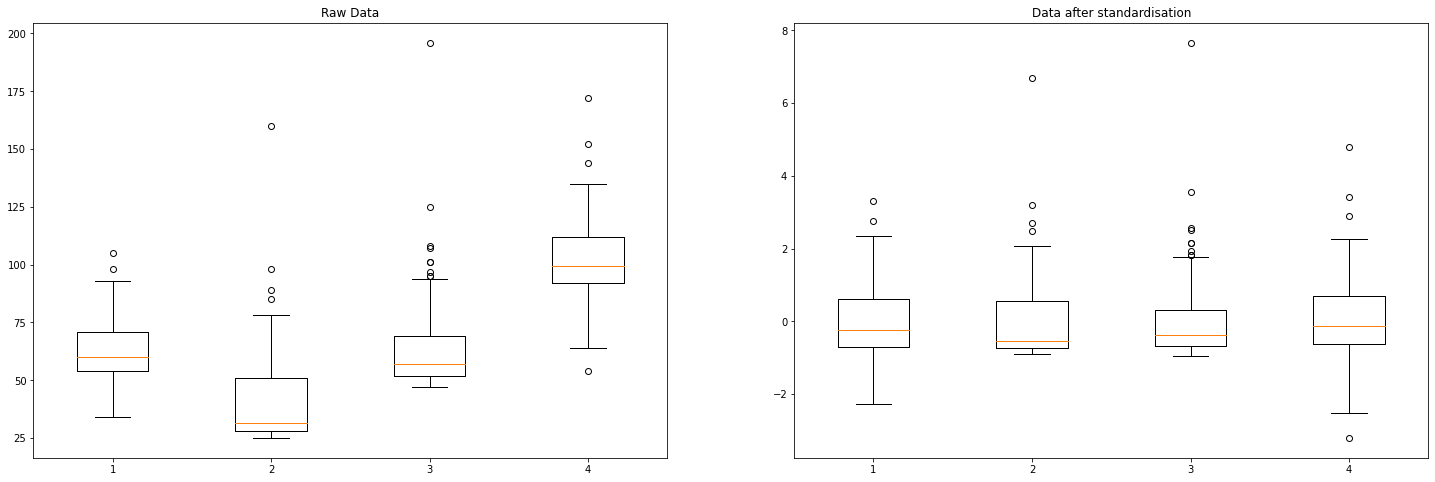

In [5]:
# get the data, we'll just grab 2 dimensions
X = train.iloc[:, 1:5].to_numpy()
train.iloc[:, 0] = train.iloc[:, 0].astype("category")
Y = train.iloc[:, 0].cat.codes.to_numpy()

# plot box plot for the data
fig = plt.figure(figsize=[25, 8])
ax = fig.add_subplot(1, 2, 1)
ax.boxplot(X)
ax.set_title('Raw Data')

# standardise data
mu = numpy.mean(X, 0)
sigma = numpy.std(X, 0)
X = (X - mu) / sigma

# box plot after standardisation
ax = fig.add_subplot(1, 2, 2)
ax.boxplot(X)
ax.set_title('Data after standardisation');

X_train = X
Y_train = Y

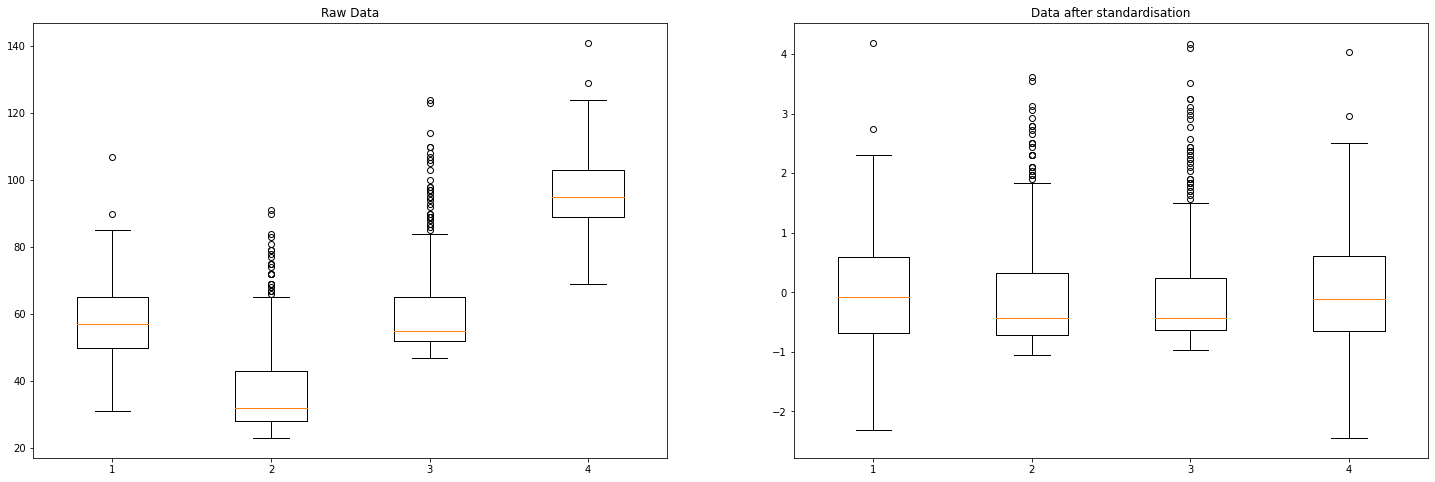

In [6]:
# get the data, we'll just grab 2 dimensions
X = test.iloc[:, 1:5].to_numpy()
test.iloc[:, 0] = test.iloc[:, 0].astype("category")
Y = test.iloc[:, 0].cat.codes.to_numpy()

# plot box plot for the data
fig = plt.figure(figsize=[25, 8])
ax = fig.add_subplot(1, 2, 1)
ax.boxplot(X)
ax.set_title('Raw Data')

# standardise data
mu = numpy.mean(X, 0)
sigma = numpy.std(X, 0)
X = (X - mu) / sigma

# box plot after standardisation
ax = fig.add_subplot(1, 2, 2)
ax.boxplot(X)
ax.set_title('Data after standardisation');

### Split test data into testing and validation sets

Split testing set (50%) and validation set (50%)

Code taken from Week 3 Example 1

In [7]:
X_test, X_val, Y_test, Y_val = train_test_split(X, Y, test_size=0.7, random_state=0)

### Check train and test data to confirm size

In [8]:
X_train.shape

(198, 4)

In [9]:
X_test.shape

(97, 4)

### Evaluate models using confusion matrix

Code taken from Week 3 Example 2

In [10]:
# function to do our eval for us, this is quite simple and will
# - create a figure
# - draw a confusion matrix for the trainign data in a sub-fig on the left
# - draw a confusion matrix for the testing data in a sub-fig on the right
# - compute the overall classification accuracy on the testing data
# this has simply been created as we're going to do this for each test that we run
def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = plot_confusion_matrix(model, X_train, Y_train, normalize=None, xticks_rotation='vertical', ax=ax)
    pred = model.predict(X_train)
    conf.ax_.set_title('Training Set Performance: ' + str(sum(pred == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = plot_confusion_matrix(model, X_test, Y_test, normalize=None, xticks_rotation='vertical', ax=ax)
    pred = model.predict(X_test)
    conf.ax_.set_title('Testing Set Performance: ' + str(sum(pred == Y_test)/len(Y_test)));

### Evaluate basic SVC model

Code taken from Week 3 Example 2

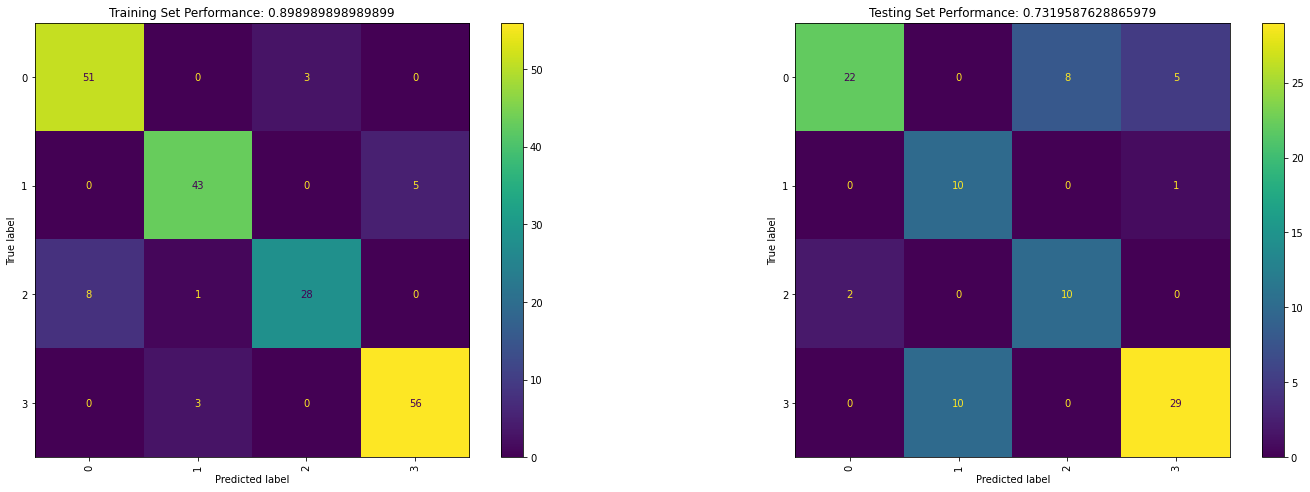

In [11]:
svm = SVC()
svm.fit(X_train, Y_train)
eval_model(svm, X_train, Y_train, X_test, Y_test)

### Set param grid to find best values

Code taken from Week 3 Example 2

## used training data

In [12]:
param_grid = [
  {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear'],'class_weight':['balanced','None']},
  {'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.12, 0.11, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf'],'class_weight':['balanced','None']},
  {'C': [0.1, 1, 10, 100, 1000], 'degree': [3, 4, 5, 6], 'kernel': ['poly'],'class_weight':['balanced','None']},
 ]
svm = SVC()

grid_search = GridSearchCV(svm, param_grid)
grid_search.fit(X_val, Y_val)
grid_search.cv_results_

er\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\svm\_base.py", line 173, in fit
    y = self._validate_targets(y)
  File "C:\Users\User\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\svm\_base.py", line 555, in _validate_targets
    self.class_weight_ = compute_class_weight(self.class_weight,
  File "C:\Users\User\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\User\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\utils\class_weight.py", line 63, in compute_class_weight
    raise ValueError("class_weight must be dict, 'balanced', or None,"
ValueError: class_weight must be dict, 'balanced', or None, got: 'None'

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\User\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Esti

rue,  True,  True,
                     True,  True,  True,  True,  True,  True,  True,  True,
                     True,  True,  True,  True,  True,  True,  True,  True,
                     True,  True,  True,  True,  True,  True,  True,  True,
                     True,  True,  True,  True,  True,  True,  True,  True,
                     True,  True,  True,  True,  True,  True,  True,  True,
                     True,  True,  True,  True,  True,  True,  True,  True,
                     True,  True,  True,  True,  True,  True, False, False,
                    False, False, False, False, False, False, False, False,
                    False, False, False, False, False, False, False, False,
                    False, False, False, False, False, False, False, False,
                    False, False, False, False, False, False, False, False,
                    False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.1, 'class_

### Use best values found from param grid as values for SVC

Code taken from Week 3 Example 2

{'C': 1, 'class_weight': 'balanced', 'kernel': 'linear'}


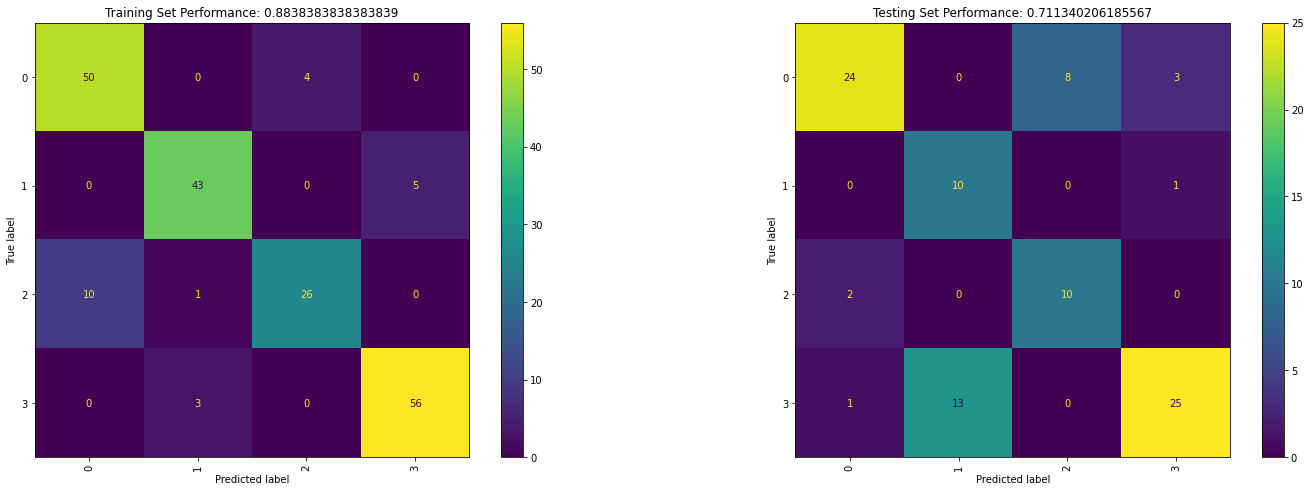

In [13]:
best_system = numpy.argmin(grid_search.cv_results_['rank_test_score'])
params = grid_search.cv_results_['params'][best_system]
print(params)
svm = SVC().set_params(**params)
svm.fit(X_train, Y_train)
eval_model(svm, X_train, Y_train, X_test, Y_test)


### validate using the validation set

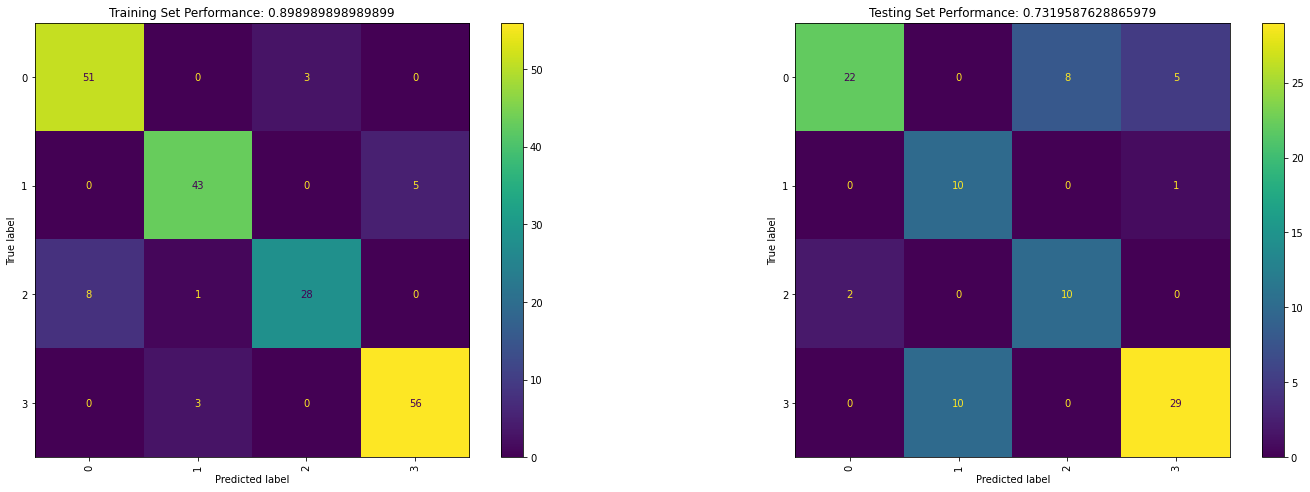

In [14]:
svm2 = SVC()
svm2.fit(X_train, Y_train)
eval_model(svm2, X_train, Y_train, X_test, Y_test)


### Evaluate model using NuSVC

Code taken from Week 3 Example 2

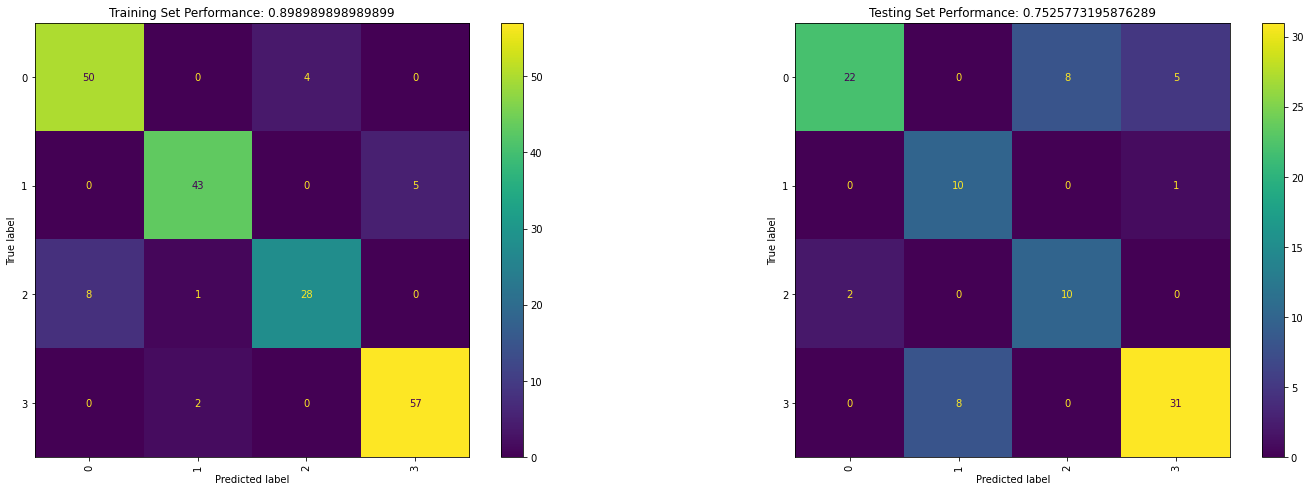

In [15]:
nu_svm = NuSVC()
nu_svm.fit(X_train, Y_train)
eval_model(nu_svm, X_train, Y_train, X_test, Y_test)

In [16]:
param_grid = [
  {'nu':[0.1,0.15,0.2,0.25], 'kernel': ['linear'],'class_weight':['balanced','None']},
  {'nu':[0.1,0.15,0.2,0.25], 'gamma': [0.15, 0.125, 0.1, 0.075, 0.05, 0.0025], 'kernel': ['rbf'],'class_weight':['balanced','None']},
  {'nu':[0.1,0.15,0.2,0.25], 'degree': [3, 4, 5, 6], 'kernel': ['poly'],'class_weight':['balanced','None']},
 ]
svm = NuSVC()

grid_search = GridSearchCV(svm, param_grid)
grid_search.fit(X_val, Y_val)
grid_search.cv_results_

ck (most recent call last):
  File "C:\Users\User\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\svm\_base.py", line 173, in fit
    y = self._validate_targets(y)
  File "C:\Users\User\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\svm\_base.py", line 555, in _validate_targets
    self.class_weight_ = compute_class_weight(self.class_weight,
  File "C:\Users\User\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\User\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\utils\class_weight.py", line 63, in compute_class_weight
    raise ValueError("class_weight must be dict, 'balanced', or None,"
ValueError: class_weight must be d

e, False, False, False, False, False,
                    False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_nu': masked_array(data=[0.1, 0.15, 0.2, 0.25, 0.1, 0.15, 0.2, 0.25, 0.1, 0.15,
                    0.2, 0.25, 0.1, 0.15, 0.2, 0.25, 0.1, 0.15, 0.2, 0.25,
                    0.1, 0.15, 0.2, 0.25, 0.1, 0.15, 0.2, 0.25, 0.1, 0.15,
                    0.2, 0.25, 0.1, 0.15, 0.2, 0.25, 0.1, 0.15, 0.2, 0.25,
                    0.1, 0.15, 0.2, 0.25, 0.1, 0.15, 0.2, 0.25, 0.1, 0.15,
                    0.2, 0.25, 0.1, 0.15, 0.2, 0.25, 0.1, 0.15, 0.2, 0.25,
                    0.1, 0.15, 0.2, 0.25, 0.1, 0.15, 0.2, 0.25, 0.1, 0.15,
                    0.2, 0.25, 0.1, 0.15, 0.2, 0.25, 0.1, 0.15, 0.2, 0.25,
                    0.1, 0.15, 0.2, 0.25, 0.1, 0.15, 0.2, 0.25],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False, False, False, False, False,
    

{'class_weight': 'balanced', 'gamma': 0.075, 'kernel': 'rbf', 'nu': 0.25}


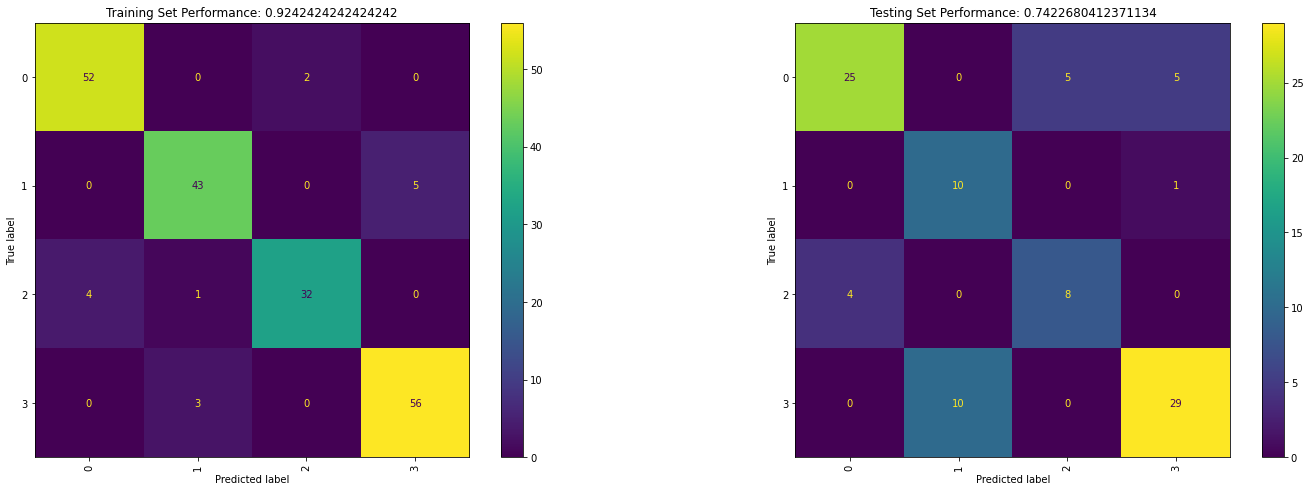

In [17]:
best_system = numpy.argmin(grid_search.cv_results_['rank_test_score'])
params = grid_search.cv_results_['params'][best_system]
print(params)
svm = NuSVC().set_params(**params)
svm.fit(X_train, Y_train)
eval_model(svm, X_train, Y_train, X_test, Y_test)

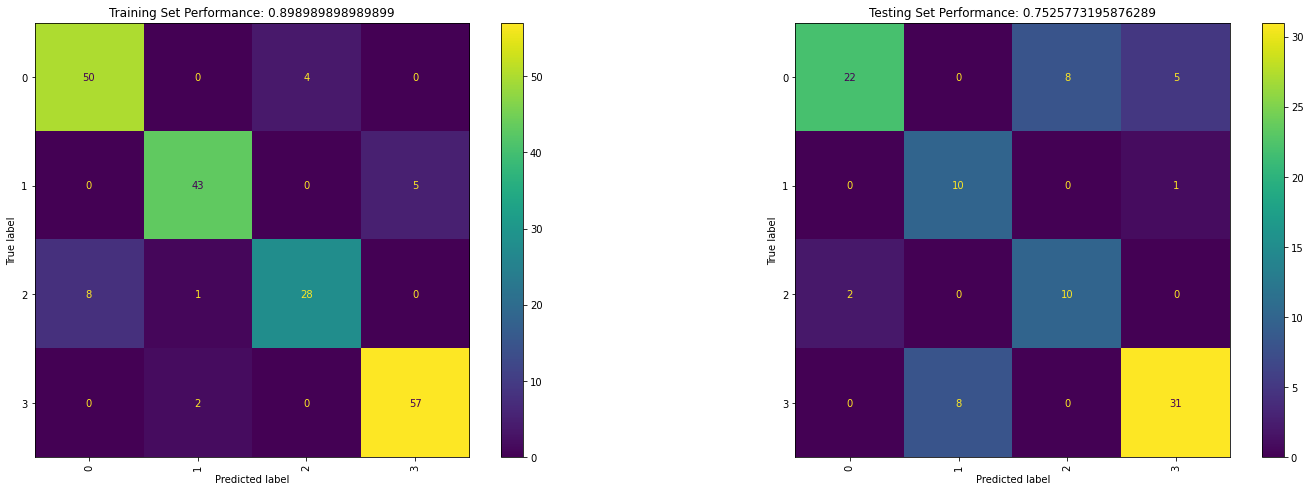

In [18]:
svm2 = NuSVC()
svm2.fit(X_train, Y_train)
eval_model(svm2, X_train, Y_train, X_test, Y_test)

### Evaluate K Nearest Neighbours model

Code taken from Week 3 Example 2

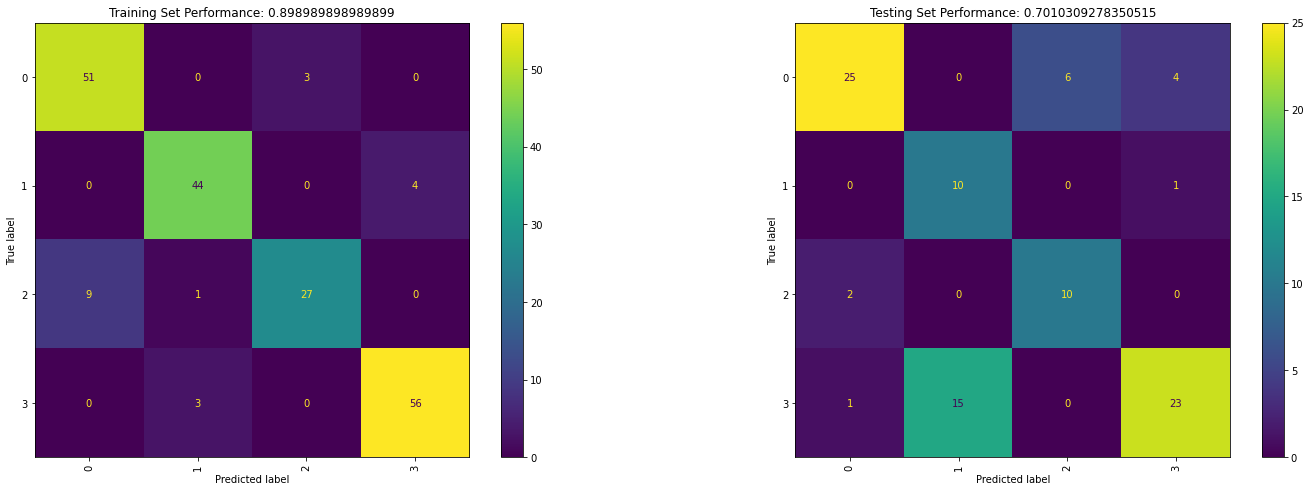

In [19]:
cknn = KNeighborsClassifier()
cknn.fit(X_train, Y_train)
eval_model(cknn, X_train, Y_train, X_test, Y_test)

### Find best values for K Nearest Neighbours

Code taken from Week 3 Example 2

In [20]:
param_grid = [
   {'n_neighbors' : list(range(1,21)), 'weights' : ['uniform', 'distance']}
 ]
cknn = KNeighborsClassifier()

grid_search = GridSearchCV(cknn, param_grid)
grid_search.fit(X_val, Y_val)
grid_search.cv_results_

{'mean_fit_time': array([0.00069456, 0.00049572, 0.00029874, 0.00049729, 0.00049596,
        0.00049591, 0.00039892, 0.00049934, 0.00039916, 0.0004941 ,
        0.00049615, 0.00049605, 0.00049596, 0.00049887, 0.00029812,
        0.00049834, 0.00029769, 0.00049596, 0.00039687, 0.00049734,
        0.00049615, 0.00049543, 0.00049596, 0.00049605, 0.00029755,
        0.0004941 , 0.00039687, 0.0004961 , 0.00049596, 0.00049596,
        0.00039692, 0.00049863, 0.00029764, 0.00029769, 0.00059643,
        0.00049586, 0.00049801, 0.00049582, 0.00049353, 0.00049472]),
 'std_fit_time': array([2.43004066e-04, 4.62310777e-07, 2.43931174e-04, 2.29378004e-06,
        1.78416128e-07, 2.61174468e-07, 1.99514468e-04, 3.14071088e-04,
        2.00601170e-04, 1.61763799e-05, 1.50789149e-07, 1.16800773e-07,
        9.53674316e-08, 3.13768148e-04, 2.43413371e-04, 4.50705715e-06,
        2.43062455e-04, 2.33601546e-07, 1.98435862e-04, 2.38894940e-06,
        2.13248060e-07, 1.32316942e-06, 2.78041453e-07, 2.431

### Evaluate K Nearest Neighbours using best values

Code taken from Week 3 Example 2

{'n_neighbors': 9, 'weights': 'distance'}


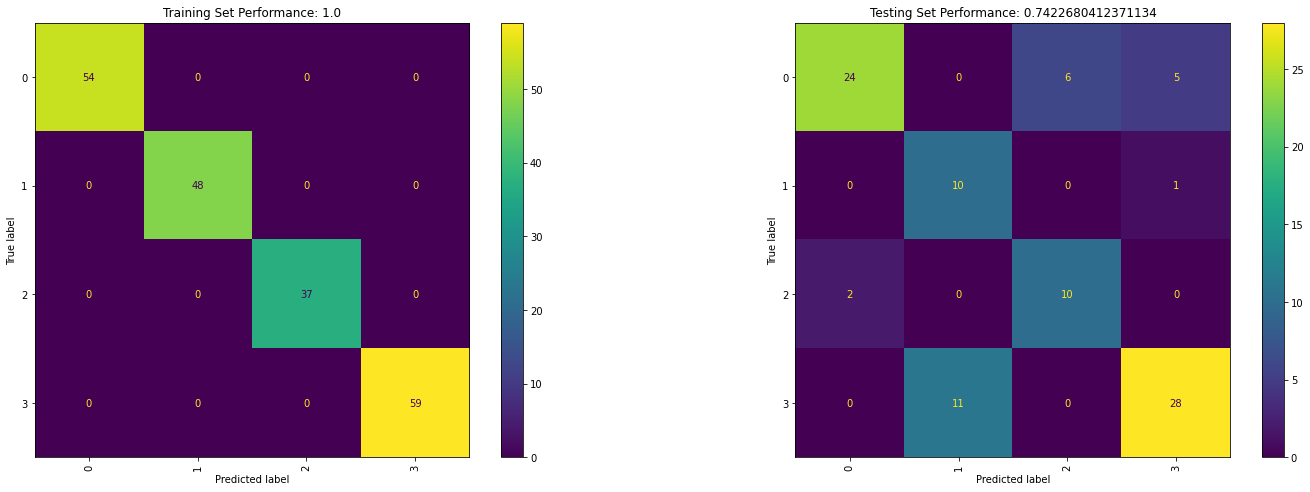

In [21]:
best_system = numpy.argmin(grid_search.cv_results_['rank_test_score'])
params = grid_search.cv_results_['params'][best_system]
print(params)
cknn = KNeighborsClassifier().set_params(**params)
cknn.fit(X_train, Y_train)
eval_model(cknn, X_train, Y_train, X_test, Y_test)

### validate 

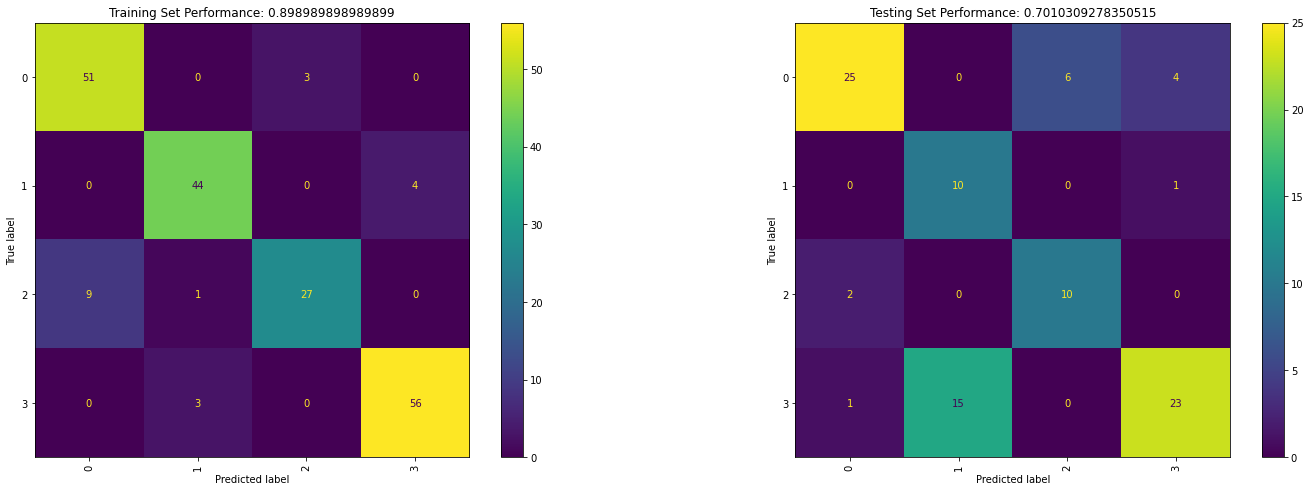

In [22]:
cknn2 = KNeighborsClassifier()
cknn2.fit(X_train, Y_train)
eval_model(cknn2, X_train, Y_train, X_test, Y_test)

### Default RFC

Code taken from Week 3 Example 2

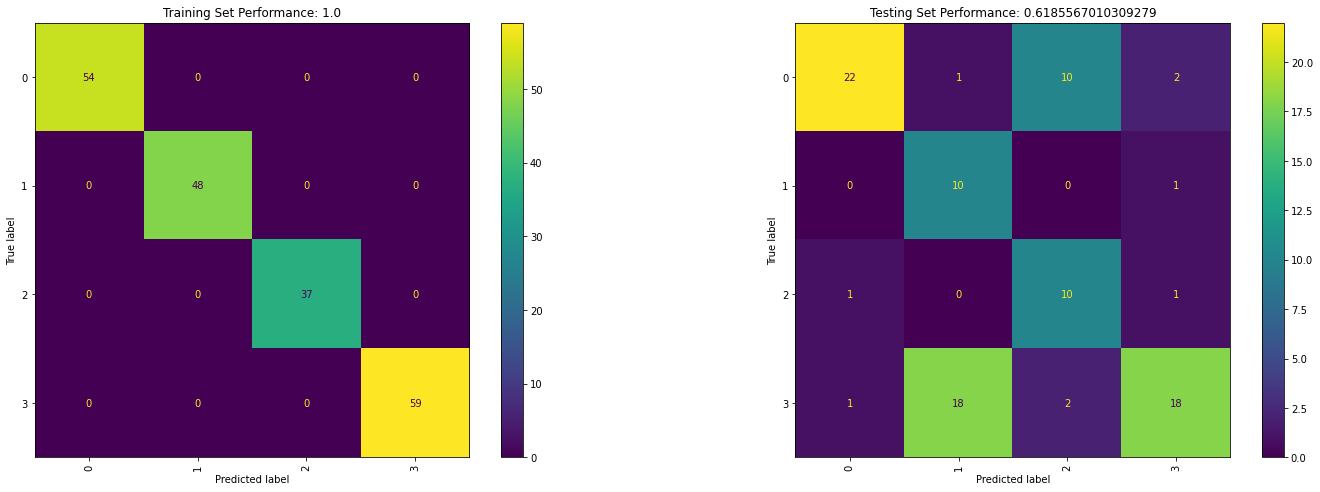

In [23]:
rf = RandomForestClassifier()
rf.fit(X_train, Y_train)
eval_model(rf, X_train, Y_train, X_test, Y_test)


### Find optimal values 


In [24]:
rf = RandomForestClassifier()
params = { 'n_estimators' : [1,10,50,100,250],'max_depth' : list(range(1,21)),'class_weight': ['balanced', 'balanced_subsample', 'None']}
grid_search = GridSearchCV(rf, params)
grid_search.fit(X_val, Y_val)
grid_search.cv_results_

ocal\Programs\Python\Python38-32\lib\site-packages\sklearn\ensemble\_forest.py", line 331, in fit
    y, expanded_class_weight = self._validate_y_class_weight(y)
  File "C:\Users\User\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\ensemble\_forest.py", line 582, in _validate_y_class_weight
    raise ValueError('Valid presets for class_weight include '
ValueError: Valid presets for class_weight include "balanced" and "balanced_subsample".Given "None".

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\User\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_

4348, 0.89130435, 0.89130435,
        0.73913043, 0.89130435, 0.86956522, 0.91304348, 0.91304348,
        0.82608696, 0.89130435, 0.91304348, 0.89130435, 0.89130435,
        0.7826087 , 0.89130435, 0.91304348, 0.89130435, 0.91304348,
        0.69565217, 0.89130435, 0.89130435, 0.91304348, 0.91304348,
        0.7826087 , 0.91304348, 0.86956522, 0.91304348, 0.91304348,
        0.73913043, 0.89130435, 0.86956522, 0.91304348, 0.91304348,
        0.76086957, 0.93478261, 0.89130435, 0.91304348, 0.89130435,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan

{'class_weight': 'balanced_subsample', 'max_depth': 18, 'n_estimators': 10}


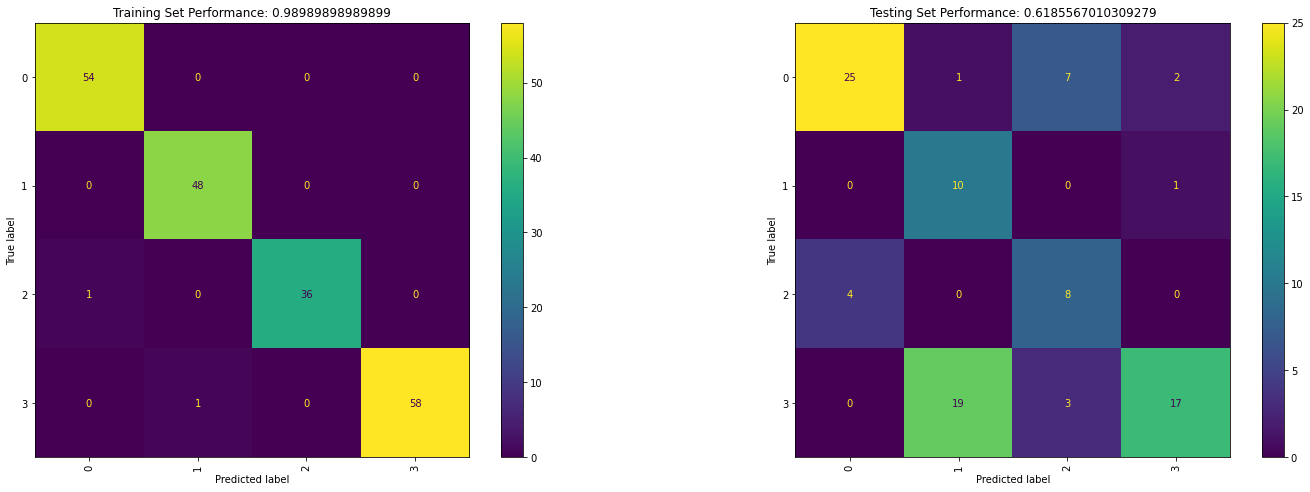

In [25]:
best_system = numpy.argmin(grid_search.cv_results_['rank_test_score'])
params = grid_search.cv_results_['params'][best_system]
print(params)
rf = RandomForestClassifier().set_params(**params)
rf.fit(X_train, Y_train)
eval_model(rf, X_train, Y_train, X_test, Y_test)

### verify using valiation

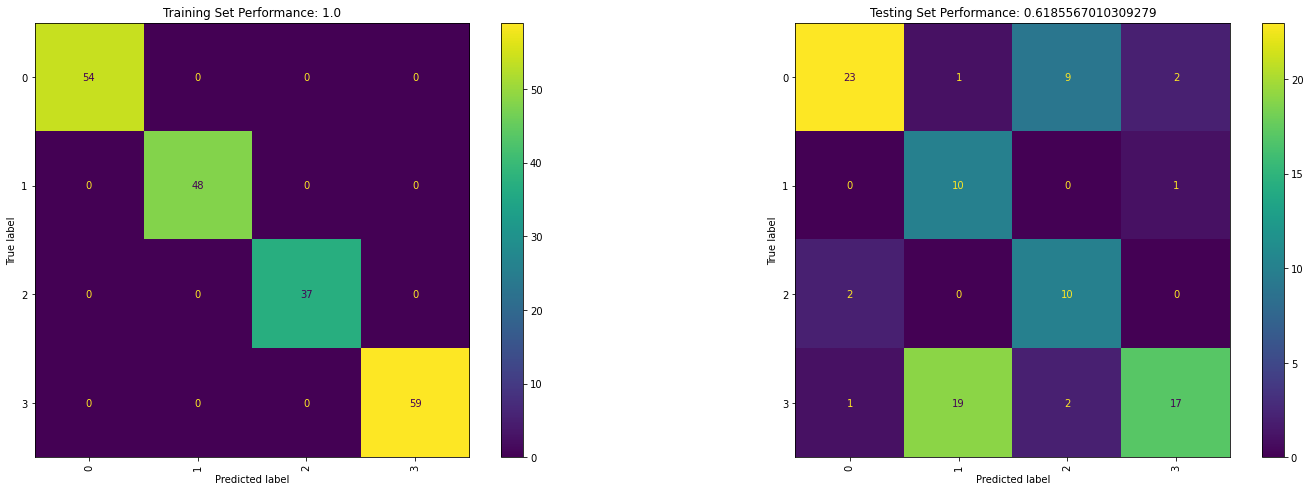

In [26]:
rf2 = RandomForestClassifier()
rf2.fit(X_train, Y_train)
eval_model(rf2, X_train, Y_train, X_test, Y_test)